# MLP in PyTorch

In [3]:
import numpy as np
import jdc
from time import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
print(torch.__version__)

2.0.1


In [4]:
torch.cuda.is_available()

False

Build a generic MLP model. [Stackoverflow](https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout) suggests the following sequence of layers in a block:

* linear layer
* [batch normalization layer](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) (optional)
* activation layer
* [dropout layer](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#dropout) (optional)

In [5]:
class MLP(nn.Module):
    def __init__(self, hidden_sizes: list[int], output_size=10, activation_func=nn.ReLU,
                 dropout_prob=None, use_batchnorm=False):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(nn.LazyLinear(hidden_sizes[0]))
            else:
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))

            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_sizes[i]))
            
            layers.append(activation_func())

            if dropout_prob is not None:
                layers.append(nn.Dropout(dropout_prob))

        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

PyTorch has the whole [zoo](https://pytorch.org/docs/stable/optim.html#algorithms) of optimizers, e.g:

* classical [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD), optionally enhanced with momentum and NAG

* one of the most popular optimizers — [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)

Feel free to experiment with any optimizer you want. The next method sets the optimizer which will be used while training:

In [6]:
%%add_to MLP
def add_optimizer(self, optim_func, param_dict=dict()):
    self.optimizer = optim_func(self.model.parameters(), **param_dict)

The next method is used to calculate validation and test accuracy:

In [7]:
%%add_to MLP
def accuracy(self, dataloader):
    self.model.eval()
    correct = 0
    total = 0
    for images, labels in dataloader:
        images = images.view(-1, 28 * 28)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    return correct / total

Add `train` method to our class:

In [23]:
%%add_to MLP
def train(self, num_epochs, batch_size):
    transform = transforms.Compose([transforms.ToTensor()])

    # Load the MNIST dataset
    train_dataset = datasets.MNIST(root='./mnist', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./mnist', train=False, transform=transform, download=True)
    
    # Split into train and validation
    train_subset, val_subset = torch.utils.data.random_split(train_dataset, [50000, 10000])
    
    # Set dataloaders
    train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

    # Set loss function
    criterion = nn.CrossEntropyLoss()

    # Training loop
    # One epoch = one pass over training dataset
    losses, train_accs, val_accs, times = [], [], [], []
    for epoch in range(num_epochs):
        begin = time()
        total_correct_train = 0
        total_samples_train = 0
        self.model.train()
        running_loss = 0.0
        
        # Iterating by mini-batches
        for i, (images, labels) in enumerate(train_loader):
            images = images.view(-1, 28 * 28)
            
            # Set all gradients to 0
            self.optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            
            # Calculate loss function
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            
            # Gradient step
            self.optimizer.step()
            running_loss += loss.item()
                
            _, predicted = torch.max(outputs, 1)
            total_correct_train += (predicted == labels).sum().item()
            total_samples_train += labels.size(0)

            if (i+1) % (len(train_loader) // 10) == 0:
                print('Epoch [{}/{}], step [{}/{}],train loss: {:.4f}, train accuracy: {:.2%}'.format(
                    epoch+1, num_epochs, i+1, len(train_loader),
                    running_loss/(i+1), total_correct_train / total_samples_train)
                )
        val_acc = self.accuracy(val_loader)
        losses.append(running_loss/len(train_loader))
        train_accs.append(total_correct_train / total_samples_train)
        val_accs.append(val_acc)
        times.append(time() - begin)
        print(f"Validation accuracy: {val_acc:.2%}")
        print(f"Epoch {epoch + 1} took {times[-1]:.3f} s")
    test_acc = self.accuracy(test_loader)
    print(f"Test accuracy: {test_acc:.2%}")
    return losses, train_accs, val_accs, test_acc, sum(times)

In [24]:
hidden_sizes = [384, 192]
model = MLP(hidden_sizes, activation_func=nn.Tanh, use_batchnorm=True)
print(model)

MLP(
  (model): Sequential(
    (0): LazyLinear(in_features=0, out_features=384, bias=True)
    (1): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=384, out_features=192, bias=True)
    (4): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): Linear(in_features=192, out_features=10, bias=True)
  )
)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [25]:
model.add_optimizer(optim.Adam)

In [26]:
n_epochs = 10
batch_size = 50
losses, train_accs, val_accs, test_acc, time_elapsed = model.train(n_epochs, batch_size)

Epoch [1/10], step [100/1000],train loss: 0.5177, train accuracy: 85.30%
Epoch [1/10], step [200/1000],train loss: 0.4465, train accuracy: 86.94%
Epoch [1/10], step [300/1000],train loss: 0.3981, train accuracy: 88.19%
Epoch [1/10], step [400/1000],train loss: 0.3638, train accuracy: 89.18%
Epoch [1/10], step [500/1000],train loss: 0.3453, train accuracy: 89.75%
Epoch [1/10], step [600/1000],train loss: 0.3290, train accuracy: 90.23%
Epoch [1/10], step [700/1000],train loss: 0.3160, train accuracy: 90.59%
Epoch [1/10], step [800/1000],train loss: 0.2994, train accuracy: 91.12%
Epoch [1/10], step [900/1000],train loss: 0.2876, train accuracy: 91.42%
Epoch [1/10], step [1000/1000],train loss: 0.2784, train accuracy: 91.74%
Validation accuracy: 93.66%
Epoch 1 took 21.652 s
Epoch [2/10], step [100/1000],train loss: 0.1751, train accuracy: 94.28%
Epoch [2/10], step [200/1000],train loss: 0.1609, train accuracy: 95.03%
Epoch [2/10], step [300/1000],train loss: 0.1637, train accuracy: 94.97%


In [12]:
%config InlineBackend.figure_formats = ['svg']

def plot_accuracy(optim_name, train_accs, val_accs, test_acc, time_elapsed):
    plt.plot(np.arange(1, n_epochs + 1), train_accs, lw=2, c='b', label="train")
    plt.plot(np.arange(1, n_epochs + 1), val_accs, lw=2, c='r', label="val")
    plt.xlim(1, n_epochs)
    plt.grid(ls=":")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title(f"NN with {len(hidden_sizes)} hidden layers and {optim_name} opt took {time_elapsed:.1f} s, test acc: {test_acc:.2%}");

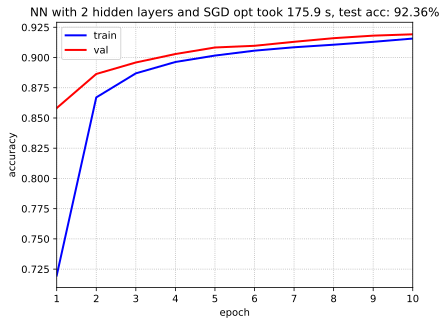

In [13]:
plot_accuracy("SGD", train_accs, val_accs, test_acc, time_elapsed)

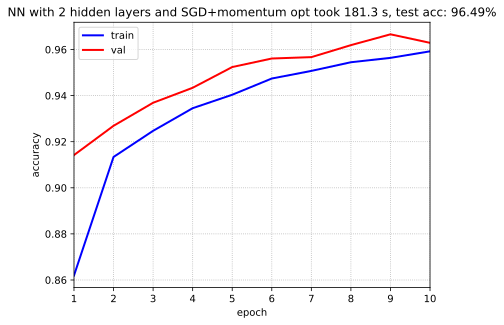

In [17]:
plot_accuracy("SGD+momentum", train_accs, val_accs, test_acc, time_elapsed)

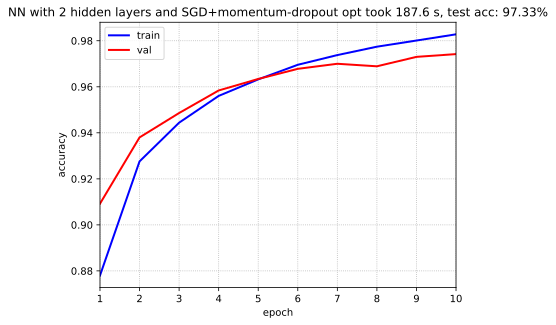

In [22]:
plot_accuracy("SGD+momentum-dropout", train_accs, val_accs, test_acc, time_elapsed)

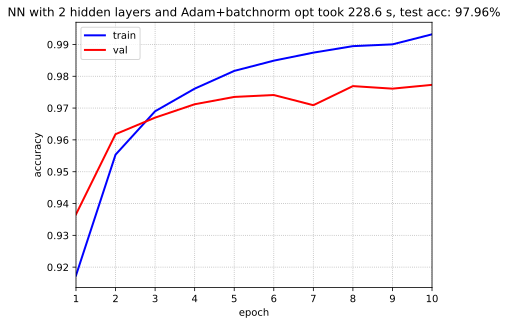

In [27]:
plot_accuracy("Adam+batchnorm", train_accs, val_accs, test_acc, time_elapsed)

DL is all about experiments. Make as many experiments with MLP on MNIST datasets and visualize your results. Things to explore:

1. Different architectures: tweak
    * number of hidden layers
    * sizes of hidden layers
    * including dropout and/or batchnorm
    * activation function

2. Tuning parameter (such as learning rate) of different optimizers: try
    * SGD 
    * Adam
    * RMSProp
    * etc
    
Do not forget to display test accuracy and training time of each model